Descriptive Statistics:
                    count          mean       std       min       25%  \
Age                 502.0 -2.494684e-16  1.000998 -1.684725 -0.867000   
Academic Pressure   502.0  8.846399e-18  1.000998 -1.443146 -0.723007   
Study Satisfaction  502.0  2.123136e-17  1.000998 -1.512765 -0.783967   
Study Hours         502.0 -1.415424e-17  1.000998 -1.712995 -0.910578   
Financial Stress    502.0 -4.600127e-17  1.000998 -1.354484 -0.652055   

                         50%       75%       max  skewness  kurtosis  
Age                 0.052940  0.768450  1.586174 -0.049843 -1.211792  
Academic Pressure  -0.002869  0.717269  1.437408 -0.011618 -1.214945  
Study Satisfaction -0.055168  0.673631  1.402429 -0.085732 -1.232836  
Study Hours         0.159311  0.961728  1.496673 -0.132925 -1.202940  
Financial Stress    0.050373  0.752802  1.455230  0.068605 -1.309048  


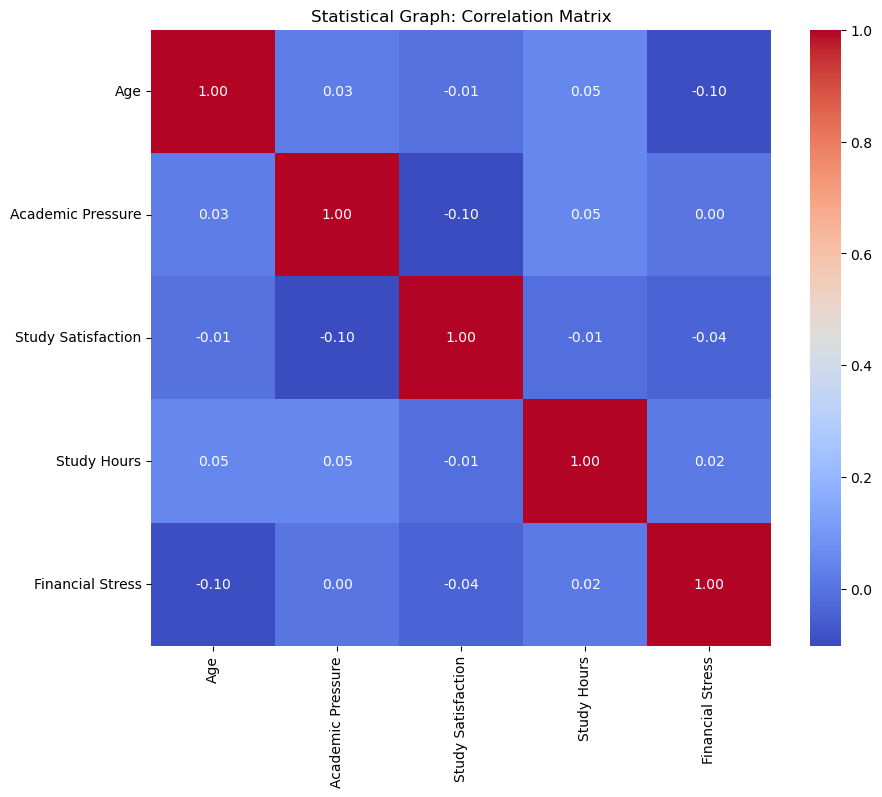

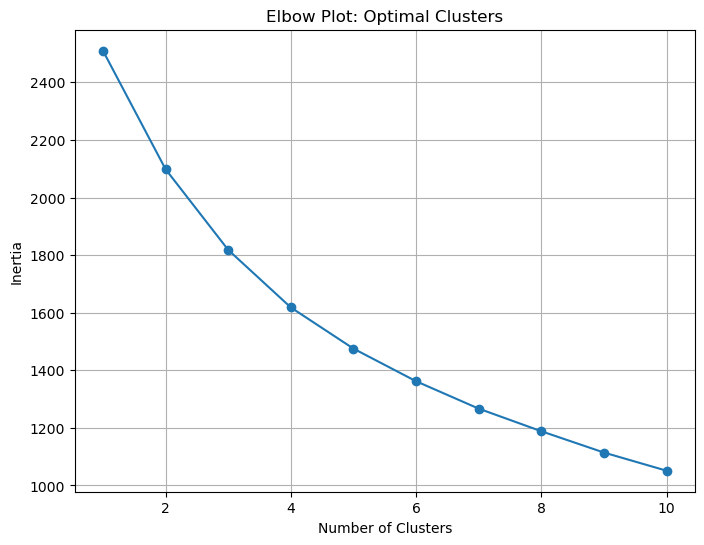

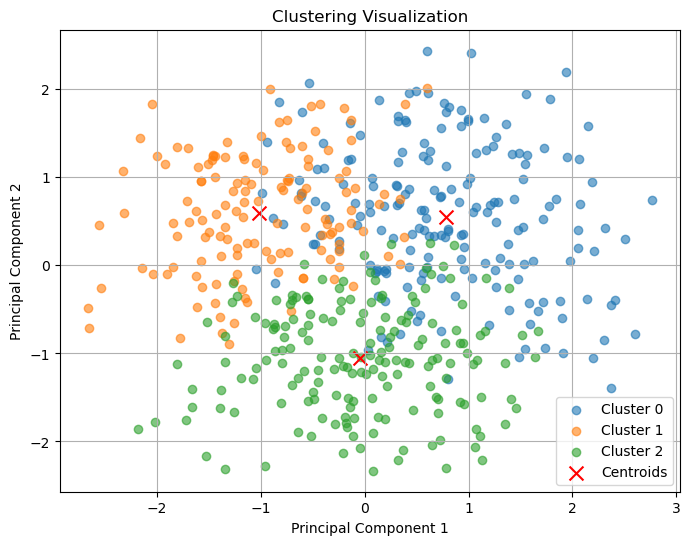

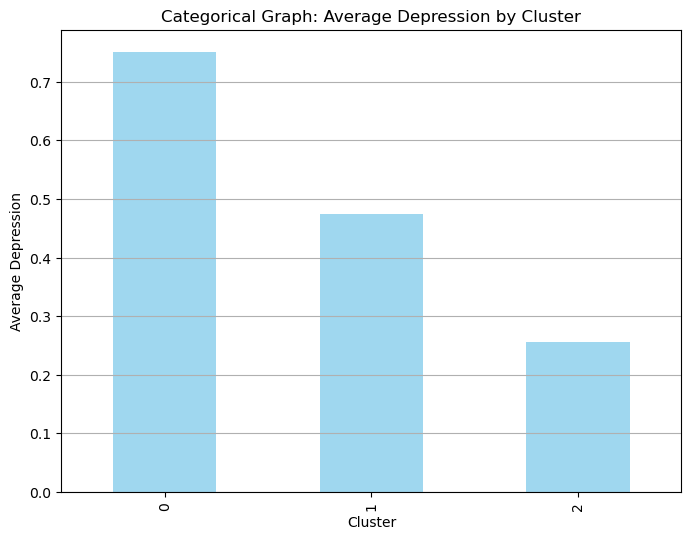

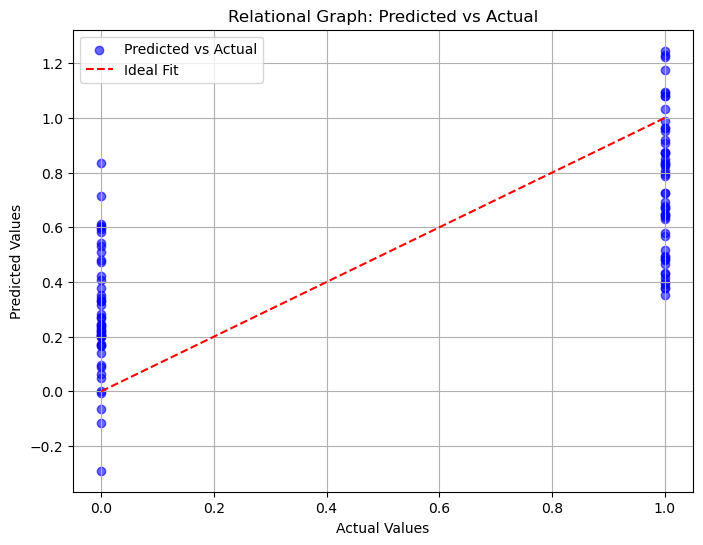

Mean Squared Error (MSE): 0.13
R-squared (R²): 0.48


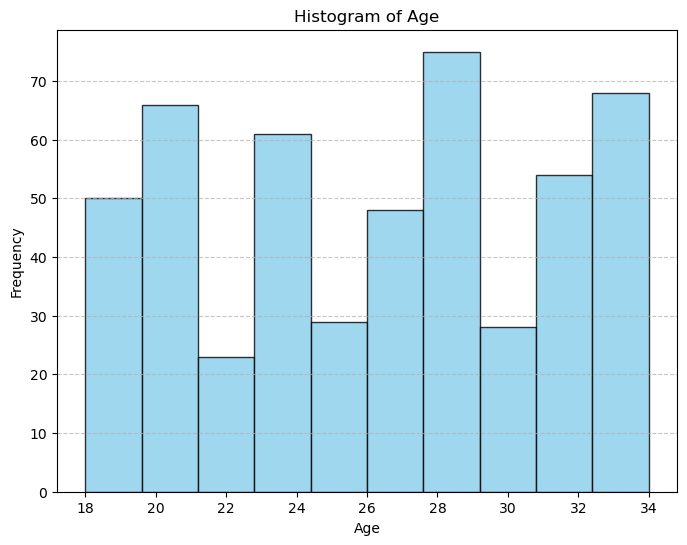

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
file_path = 'Depression Student Dataset.csv'
dataset = pd.read_csv(file_path)

# Step 1: Encoding Categorical Variables
def encode_categorical_columns(dataset, columns):
    """
    Converts categorical columns to numeric format using Label Encoding.
    """
    encoder = LabelEncoder()
    for column in columns:
        dataset[column] = encoder.fit_transform(dataset[column])
    return dataset

# List of categorical columns to encode
categorical_columns = [
    "Gender",
    "Sleep Duration",
    "Dietary Habits",
    "Have you ever had suicidal thoughts ?",
    "Family History of Mental Illness",
    "Depression"
]

# Encode categorical columns
dataset_encoded = encode_categorical_columns(dataset.copy(), categorical_columns)

# Step 2: Normalizing Numerical Columns
def normalize_columns(dataset, columns):
    """
    Normalizes numerical columns to bring all values into a similar range.
    """
    scaler = StandardScaler()
    dataset[columns] = scaler.fit_transform(dataset[columns])
    return dataset

# List of numerical columns to normalize
numerical_columns = [
    "Age",
    "Academic Pressure",
    "Study Satisfaction",
    "Study Hours",
    "Financial Stress"
]

# Normalize numerical columns
dataset_normalized = normalize_columns(dataset_encoded, numerical_columns)

# Step 3: Descriptive Statistics and Correlation Matrix
def compute_statistics(data, numerical_columns):
    """
    Displays descriptive statistics and a heatmap of the correlation matrix.
    """
    # Calculate and display descriptive statistics
    stats = data[numerical_columns].describe().T
    stats['skewness'] = data[numerical_columns].skew()
    stats['kurtosis'] = data[numerical_columns].kurt()
    print("Descriptive Statistics:")
    print(stats)

    # Visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title('Statistical Graph: Correlation Matrix')
    plt.show()

# Compute statistics for numerical columns
compute_statistics(dataset_normalized, numerical_columns)

# Step 4: Determine Optimal Clusters Using the Elbow Method
def plot_elbow_method(data, max_clusters=10):
    """
    Uses the elbow method to identify the optimal number of clusters.
    """
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
   
    # Plot the elbow method graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Plot: Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

# Plot elbow method for optimal clusters
plot_elbow_method(dataset_normalized[numerical_columns])

# Step 5: Perform K-Means Clustering
def perform_kmeans_clustering(data, n_clusters):
    """
    Performs K-Means clustering and returns cluster labels and centroids.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans.cluster_centers_

def visualize_clusters(data, cluster_labels, centroids, title="Clustering Visualization"):
    """
    Visualizes clusters using PCA to reduce dimensions to 2 components.
    """
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    reduced_centroids = pca.transform(centroids)
   
    plt.figure(figsize=(8, 6))
    for cluster in np.unique(cluster_labels):
        cluster_points = reduced_data[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)
   
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], color='red', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform clustering and visualize results
optimal_clusters = 3
cluster_labels, centroids = perform_kmeans_clustering(dataset_normalized[numerical_columns], optimal_clusters)
visualize_clusters(dataset_normalized[numerical_columns], cluster_labels, centroids)

# Step 6: Average Depression by Cluster
def plot_categorical_graph(data, clusters, target):
    """
    Plots the average target value for each cluster as a bar chart.
    """
    data['Cluster'] = clusters
    cluster_summary = data.groupby('Cluster')[target].mean()
   
    plt.figure(figsize=(8, 6))
    cluster_summary.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Categorical Graph: Average Depression by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {target}')
    plt.grid(axis='y')
    plt.show()

# Plot categorical graph for average depression
plot_categorical_graph(dataset_normalized, cluster_labels, 'Depression')

# Step 7: Regression Analysis
def train_and_evaluate_regression(data, features, target):
    """
    Trains a linear regression model and evaluates its performance.
    """
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
   
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
   
    # Visualize regression predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual', color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
    plt.title('Relational Graph: Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()
   
    return mse, r2

# Perform regression analysis
features = numerical_columns
target = "Depression"
mse, r2 = train_and_evaluate_regression(dataset_normalized, features, target)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Step 8: Histogram of Age Distribution
def plot_histogram(data, column):
    """
    Creates a histogram to display the distribution of a numerical column.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data[column], bins=10, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot histogram for age distribution
plot_histogram(dataset, "Age")